## read results 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from hockey.visualization.pygame.animate_hockey_game import read_and_merge_dataframes

## Helper function(s)

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


## Display matrix as heatmap


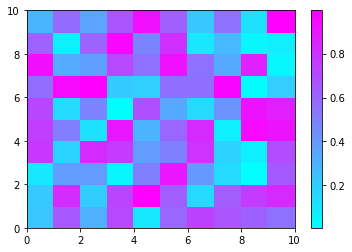

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, axis = plt.subplots()
a = np.random.random((10, 10)) # ((16, 16))
heatmap = axis.pcolor(a, cmap=plt.cm.cool) # Blues)
# plt.imshow(a, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

In [6]:
a[0,1]


0.6550593354759412

## Create Evaluator

In [10]:
import pickle
import time
import os
import random
from pathlib import Path
import numpy as np
from typing import Callable, Optional, Tuple

from geometry.point import Point
from geometry.vector import Vec2d, X_UNIT_VECTOR
from hockey.behaviour.core.action import HockeyAction
from hockey.core.half_rink import HockeyHalfRink

from hockey.behaviour.core.hockey_scenario import GrabThePuckProblem


# *********************************************


hockeyworld = HockeyHalfRink(
    width=HockeyHalfRink.WIDTH_HALF_ICE, 
    height=HockeyHalfRink.HEIGHT_ICE, 
    how_many_defense=0, 
    how_many_offense=1,
    one_step_in_seconds=1,
    collect_data_every_secs=1, 
    record_this_many_minutes=1)
basic_fwd_problem = GrabThePuckProblem(hockeyworld)
total_actions = len(basic_fwd_problem.get_possible_actions())


Half-ice rink reset
TURN_HARD_LEFT
TURN_HARD_RIGHT
SKATE_MIN_SPEED
Half-ice rink reset
[scenario reset] ice world = [puck] taken = False, pos = (0.00, 0.00), speed = Vec2d(0, 0), KINETIC_FRICTION_COEF = 0.07
Goals scored: 0; shots = 0
Defensive squad:

Offensive squad:
height = 6.23 feet, reach = 1.00 feet
position: (4.00, 4.00)
speed: Vec2d(-0.0, -0.0) (norm = 0.00 feet/sec)
Have puck = False

reward_shot = 33.33
reward_get_puck = 3.33
punishment_action_failed = -0.50
punishment_loss_energy = -1.00


In [ ]:
perfs_dict = {}
brain_root_dir = "/Users/luisd/luis-simulation/models/speed1_small"
episodes = [1,10,20, 21, 22, 50, 51, 52, 200, 201,202, 500, 501, 502,600, 601, 602,800, 801, 802,]
episodes = [20, 600]

quality = {}
for episode in episodes:
    brain_file_name = os.path.join(brain_root_dir, "brain_episode_%d.bin" % (episode))
    print("Going for episode %d (file: '%s')" % (episode, brain_file_name))
    evaluator = Evaluator(player=hockeyworld.attack[0], 
                          load_from_full_file_name=brain_file_name, 
                          total_number_of_actions=total_actions, steps_in_height=1, steps_in_widht=1)
    # quality_wrapper = QualityWrapper(evaluator, brain_file_name)
    quality[episode] = (0, 0)
    # looking at puck
    mean_value, std_value = evaluator.quality_when_looking_at_puck()
    print("[looking at puck] mean = %.2f, std-dev: %.2f" % (mean_value, std_value))
    m, s = quality[episode]
    quality[episode] = (m + mean_value, s + std_value)
    # looking at left of puck
    mean_value, std_value = evaluator.quality_when_looking_at_left()
    print("[looking at left of puck] mean = %.2f, std-dev: %.2f" % (mean_value, std_value))
    m, s = quality[episode]
    quality[episode] = (m + mean_value, s + std_value)
    # looking at right of puck
    mean_value, std_value = evaluator.quality_when_looking_at_right()
    print("[looking at right of puck] mean = %.2f, std-dev: %.2f" % (mean_value, std_value))
    m, s = quality[episode]
    quality[episode] = (m + mean_value, s + std_value)
    # average the whole thing (I don't know...!!)
    m, s = quality[episode]
    quality[episode] = (m/3, s/3)

In [ ]:
quality

In [ ]:
means = [v[0] for v in list(quality.values())]
std_devs = [v[1] for v in list(quality.values())]
plt.plot(list(quality.keys()), means, 'ro:')
_ = plt.xlabel("Episodes")
_ = plt.ylabel("Quality of Learning")
_ = plt.title("[mean] Quality of Learning (1 == perfect, 0 = stupid)")


In [ ]:
#
plt.plot(list(quality.keys()), std_devs, 'ro:')
_ = plt.xlabel("Episodes")
_ = plt.ylabel("std-dev")
_ = plt.title("[std-dev] Quality of Learning")

In [ ]:
perfs_dict = {}
# . "/Users/luisd/luis-simulation/models/speed1_small"
def display_for_episode(
    brain_root_dir: str,
    episode: int, 
    recreate: bool,
    do_warm_up: bool,
    show_adequacy: bool = True, 
    show_distance: bool = True, 
    show_sensing: bool = True,
    height_range = None, width_range = None):
    if recreate and (episode in perfs_dict):
        del perfs_dict[episode]
    if episode not in perfs_dict:
        brain_file_name = os.path.join(brain_root_dir, "brain_episode_%d.bin" % (episode))
        evaluator = Evaluator(player=hockeyworld.attack[0], 
                              load_from_full_file_name=brain_file_name, 
                              total_number_of_actions=total_actions, steps_in_height=1, steps_in_widht=1)
        matrix_for_aligning2(
            evaluator,
            do_warm_up,
            compare_with=None, 
            verbose = False)
        perfs_dict[episode] = (brain_file_name, evaluator)
    brain_file_name, evaluator = perfs_dict[episode]
    # display
    if show_adequacy:
        show_actions_adequacy(episode, brain_file_name, evaluator, height_range, width_range)
    if show_distance:
        show_distance_to_optimal_action(episode, brain_file_name, evaluator, height_range, width_range)
    if show_sensing:
        show_sensings(episode, brain_file_name, evaluator, height_range, width_range)
    return evaluator, r_matrix_looking_fwd


# without warm-up


In [ ]:
_ = display_for_episode(episode = 600,
                                  recreate = False,
                    do_warm_up = False,
                    show_adequacy = True, 
                    show_distance = False, 
                    show_sensing = False)
_ = display_for_episode(episode = 601,
                                  recreate = False,
                    do_warm_up = False,
                    show_adequacy = True, 
                    show_distance = False, 
                    show_sensing = False)
_ = display_for_episode(episode = 502,
                                  recreate = False,
                    do_warm_up = False,
                    show_adequacy = True, 
                    show_distance = False, 
                    show_sensing = False)
_ = display_for_episode(episode = 1601,
                                  recreate = False,
                    do_warm_up = False,
                    show_adequacy = True, 
                    show_distance = False, 
                    show_sensing = False)
_ = display_for_episode(episode = 1602,
                                  recreate = False,
                    do_warm_up = False,
                    show_adequacy = True, 
                    show_distance = False, 
                    show_sensing = False)
# ev_with_warmup, m_with_warmup = display_for_episode(episode = 500,
#                                   recreate = True,
#                     do_warm_up = True,
#                     show_adequacy = True, 
#                     show_distance = False, 
#                     show_sensing = False)
# m_with_warmup2 = display_for_episode(episode = 500,
#                                   recreate = True,
#                     do_warm_up = True,
#                     show_adequacy = True, 
#                     show_distance = False, 
#                     show_sensing = False)

In [ ]:
np.allclose(ev_no_warmup.sensing_matrix, ev_with_warmup.sensing_matrix)

In [ ]:
len(np.where(m_no_warmup != m_with_warmup)[0])

In [ ]:
m1 = m_with_warmup
m2 = m_no_warmup # m_with_warmup2
# MM = np.subtract(m_no_warmup, m_with_warmup)
if len(np.where(m1 != m2)[0]) == 0:
    print("These 2 matrixes are the same")
else:
    MM = np.subtract(m1, m2)

    fig, axis = plt.subplots()
    heatmap = axis.pcolor(
        MM,
        cmap=plt.cm.RdBu)  # afmhot, brg, cool or Blues)
    plt.colorbar(heatmap)
    # problem_descr = "puck static at (0,0); player starts at upper right-corner"
    # plt.title("Problem: %s\nEpisode: %d, Score: %.2f +/- %.2f, Source: \n'%s'" %
    #           (problem_descr, episode, mean_value, std_value, brain_file_name))
    plt.show()



In [ ]:
len(np.unique(MM))

In [ ]:
np.where(MM != 0)

In [ ]:
NewRange = (1 - 0)
OldRange = (np.amax(ev_no_warmup.sensing_matrix - np.amin(ev_no_warmup.sensing_matrix)))
new_min = 0
NewSensingMatrix = (((ev_no_warmup.sensing_matrix - np.amin(ev_no_warmup.sensing_matrix)) * NewRange) / OldRange) + new_min
# 
MM2 = np.multiply(MM, NewSensingMatrix)
len(np.unique(MM2))

In [ ]:
MM2[81,:]

In [ ]:
fig, axis = plt.subplots()
tt = max(abs(np.amin(MM2)), abs(np.amax(MM2)))
heatmap = axis.pcolor(
    MM2,
    cmap=plt.cm.RdBu, vmin=-tt, vmax=tt)  # afmhot, brg, cool or Blues)
plt.colorbar(heatmap)
# problem_descr = "puck static at (0,0); player starts at upper right-corner"
# plt.title("Problem: %s\nEpisode: %d, Score: %.2f +/- %.2f, Source: \n'%s'" %
#           (problem_descr, episode, mean_value, std_value, brain_file_name))
plt.show()


# WITH warm-up

In [ ]:
display_for_episode(episode = 100, 
                    show_adequacy = True, 
                    show_distance = True, 
                    show_sensing = True)

# without warm-up


In [ ]:
recreate_stuff = False
show_adq = True
_ = display_for_episode(episode = 148, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 149, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 150, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 151, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 152, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 248, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 249, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 250, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 251, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 252, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
# _ = display_for_episode(episode = 253, recreate = recreate_stuff, do_warm_up = False, 
#                     show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 348, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 349, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 350, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 351, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 352, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 353, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 600, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 601, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 602, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 610, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1000, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1001, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1002, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1010, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1200, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1201, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1202, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)
_ = display_for_episode(episode = 1210, recreate = recreate_stuff, do_warm_up = False, 
                    show_adequacy = show_adq, show_distance = False, show_sensing = False)


In [ ]:
plt.plot(
    [148, 149, 150, 151, 152,248, 249, 250, 251, 252,253, 348, 349, 350, 351, 352, 353, 600, 601, 602, 610], 
    [0 , 0.18, 0.34, 0.35, 0.27,0.48, 0.28, 0.09, 0.37, 0.08,0.37, 0.25, 0.28, 0.4, 0.2, 0.15, 0, 0.27, 0.38, 0.04, 0.17], 'rx:')
# plt.axis([0, 6, 0, 20])
plt.show()

In [ ]:
display_for_episode(episode = 10, show_adequacy = True, show_distance = False, show_sensing = False)
display_for_episode(episode = 50, show_adequacy = True, show_distance = False, show_sensing = False)
display_for_episode(episode = 70, show_adequacy = True, show_distance = False, show_sensing = False)
display_for_episode(episode = 100, show_adequacy = True, show_distance = False, show_sensing = False)
display_for_episode(episode = 300, show_adequacy = True, show_distance = False, show_sensing = False)
display_for_episode(episode = 500, show_adequacy = True, show_distance = False, show_sensing = False)

In [ ]:
display_for_episode(episode = 100, 
                    show_adequacy = True, 
                    show_distance = True, 
                    show_sensing = True, 
                    height_range = slice(50,70), 
                    width_range = slice(70,80))

In [ ]:
brain_file_name, r_matrix_looking_fwd, evaluator = perfs_dict[100]
x_range = slice(2) # slice(1,3) #[0:10]
y_range = slice(1,5)
evaluator.sensing_matrix[x_range, y_range]
# evaluator.sensing_matrix[1:3, 1:5]

In [ ]:
1:3

In [ ]:
display_for_episode(episode = 380, show_adequacy = True, show_distance = True)

In [ ]:
display_for_episode(episode = 10, show_adequacy = True, show_distance = True)

In [ ]:
display_for_episode(episode = 30, show_adequacy = True, show_distance = False)
display_for_episode(episode = 50, show_adequacy = True, show_distance = False)
display_for_episode(episode = 100, show_adequacy = True, show_distance = False)
display_for_episode(episode = 200, show_adequacy = True, show_distance = False)
display_for_episode(episode = 300, show_adequacy = True, show_distance = False)
display_for_episode(episode = 400, show_adequacy = True, show_distance = False)

# display_for_episode(episode = 33, show_adequacy = False, show_distance = True)
# display_for_episode(episode = 34, show_adequacy = False, show_distance = True)
# display_for_episode(episode = 35, show_adequacy = False, show_distance = True)
# display_for_episode(episode = 36, show_adequacy = False, show_distance = True)

In [ ]:
# display_for_episode(episode = 299, show_adequacy = False, show_distance = True)
# del perfs_dict[100]
display_for_episode(episode = 100, show_adequacy = True, show_distance = True)
# display_for_episode(episode = 302, show_adequacy = False, show_distance = True)
# display_for_episode(episode = 305, show_adequacy = False, show_distance = True)
# display_for_episode(episode = 310, show_adequacy = False, show_distance = True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axis = plt.subplots()
# a = np.random.random((100, 100)) # ((16, 16))
episode = episodes[0]
brain_file_name, r_matrix_looking_fwd = dict_looking_at[episode]
heatmap = axis.pcolor(r_matrix_looking_fwd, cmap=plt.cm.afmhot, vmin=0, vmax=1) # brg, cool or Blues)
# plt.imshow(a, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
problem_descr = "puck static at (0,0); player starts at upper right-corner"
plt.title("Problem: %s\nEpisode: %d, Source: \n'%s'" % (problem_descr, episode, brain_file_name))
plt.show()

In [ ]:
len(np.unique(evaluator.sensing_matrix))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
for i, axis in enumerate(axn.flat):
    heatmap = axis.pcolor(r_matrix_looking_fwd, cmap=plt.cm.afmhot, vmin=0, vmax=1) # brg, cool or Blues)
    # axis.set_title("Episode: %d, Source: \n'%s'" % (episode, brain_file_name))
    axis.set_title("Episode: %d" % (episode))
plt.colorbar(heatmap)
problem_descr = "puck static at (0,0); player starts at upper right-corner\n Root dir for brain: %s" % (brain_root_dir)
# plt.title("Episode: %d, Source: \n'%s'" % (episode, brain_file_name))
plt.suptitle(problem_descr)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(episode, brain_file_name, matrix_with_values):
    fig, axis = plt.subplots()
    # a = np.random.random((100, 100)) # ((16, 16))
    heatmap = axis.pcolor(matrix_with_values, cmap=plt.cm.brg) # cool or Blues)
    # plt.imshow(a, cmap='hot', interpolation='nearest')
    plt.colorbar(heatmap)
    problem_descr = "puck static at (0,0); player starts at upper right-corner"
    plt.title("Problem: %s\nEpisode: %d, Source: \n'%s'" % (problem_descr, episode, brain_file_name))
    plt.show()
for the_episode, file_and_matrix in dict_looking_at.items():
    brain_file_name, r_matrix_looking_fwd = file_and_matrix
    plot_matrix(episode, brain_file_name, r_matrix_looking_fwd)

In [ ]:
r_matrix_looking_fwd[0,64]

In [ ]:
r_matrix_looking_fwd2[0,64]

In [ ]:
np.where(r_matrix_looking_left != r_matrix_looking_left2)


In [ ]:
def look_at_puck(p: Player):
    p.speed = X_UNIT_VECTOR
    p.align_with_puck()

def do_to_player(ice_rink: HockeyHalfRink, pre_sense_fn) -> Player:
    p1 = hockeyworld.attack[0]
    p1.model.space.place_agent(p1, pos=Point(3, 6))
    pre_sense_fn(p1)
    return p1

hockeyworld = HockeyHalfRink(how_many_defense=0, how_many_offense=1,
                             # following parameters don't matter
                             one_step_in_seconds=1, collect_data_every_secs=1, record_this_many_minutes=1)
p1 = do_to_player(hockeyworld, look_at_puck)
hockeyworld2 = HockeyHalfRink(how_many_defense=0, how_many_offense=1,
                             # following parameters don't matter
                             one_step_in_seconds=1, collect_data_every_secs=1, record_this_many_minutes=1)
p2 = do_to_player(hockeyworld2, look_at_puck)



In [ ]:
situation_sensed1 = BitstringEnvironmentState(full_state=p1.sense()).as_bitstring()
situation_sensed2 = BitstringEnvironmentState(full_state=p2.sense()).as_bitstring()

In [ ]:
situation_sensed1

In [ ]:
situation_sensed2

In [ ]:
situation_sensed1 == situation_sensed2

In [ ]:
p1 == p2

In [ ]:
# quick demo
def look_at_puck(p: Player):
    p.speed = X_UNIT_VECTOR
    p.align_with_puck()
#     assert p.on_top_of_puck() or 
#     (p.vector_looking_at() == p.model.vector_to_puck(p.pos).normalized()), 
#     "p.vector_looking_at() =%s, p.model.vector_to_puck(p.pos).normalized() = %s" % (p.vector_looking_at(), p.model.vector_to_puck(p.pos).normalized())

hockeyworld = HockeyHalfRink(how_many_defense=0, how_many_offense=1,
                             # following parameters don't matter
                             one_step_in_seconds=1, collect_data_every_secs=1, record_this_many_minutes=1)
print("+++++++++++++++ Puck position: %s" % (hockeyworld.puck.pos))
evaluator = Evaluator(player=hockeyworld.attack[0], load_from_full_file_name=brain_file_name)
m1 = evaluator.evaluation_matrix(pre_sense_fn=look_at_puck,
                                       optimal_action=HockeyAction.SKATE_MIN_SPEED)
hockeyworld2 = HockeyHalfRink(how_many_defense=0, how_many_offense=1,
                             # following parameters don't matter
                             one_step_in_seconds=1, collect_data_every_secs=1, record_this_many_minutes=1)
print("+++++++++++++++ Puck position: %s" % (hockeyworld2.puck.pos))
evaluator = Evaluator(player=hockeyworld.attack[0], load_from_full_file_name=brain_file_name)
m2 = evaluator.evaluation_matrix(pre_sense_fn=look_at_puck,
                                       optimal_action=HockeyAction.SKATE_MIN_SPEED)
m3 = evaluator.evaluation_matrix(pre_sense_fn=look_at_puck,
                                       optimal_action=HockeyAction.SKATE_MIN_SPEED)


In [ ]:
np.all(m2 == m3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axis = plt.subplots()
a = np.random.random((1000, 100)) # ((16, 16))
heatmap = axis.pcolor(a, cmap=plt.cm.brg) # cool or Blues)
# heatmap = axis.pcolor(r_matrix_looking_left, cmap=plt.cm.brg) # cool or Blues)
# plt.imshow(a, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Some random data
values1 = r_matrix_looking_left # np.random.rand(10,10)
values2 = np.random.rand(10,10)
values3 = np.random.rand(10,10)
values4 = np.random.rand(10,10)
vals = [values1,values2,values3,values4]

fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for val, ax in zip(vals,grid):
    im = ax.imshow(val, vmin=0, vmax=1)

grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(False)

plt.show()